# Argument Mining & NLP

Academic project – Master 2 Artificial Intelligence  
Author: Lynda Benkerrou


In [ ]:
!git clone https://github.com/bencrabbe/argumentation_base.git

Cloning into 'argumentation_base'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 77 (delta 35), reused 61 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 18.50 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [ ]:
%cd argumentation_base/data

/content/argumentation_base/data


In [ ]:
!sh download_data.sh

--2025-02-17 12:18:22--  https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/2422/ArgumentAnnotatedEssays-2.0.zip
Resolving tudatalib.ulb.tu-darmstadt.de (tudatalib.ulb.tu-darmstadt.de)... 130.83.152.157
Connecting to tudatalib.ulb.tu-darmstadt.de (tudatalib.ulb.tu-darmstadt.de)|130.83.152.157|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/zip]
Saving to: ‘ArgumentAnnotatedEssays-2.0.zip’

ArgumentAnnotatedEs     [   <=>              ]   1.97M  2.83MB/s    in 0.7s    

Last-modified header invalid -- time-stamp ignored.
2025-02-17 12:18:24 (2.83 MB/s) - ‘ArgumentAnnotatedEssays-2.0.zip’ saved [2064482]

Archive:  ArgumentAnnotatedEssays-2.0.zip
   creating: ArgumentAnnotatedEssays-2.0/
  inflating: ArgumentAnnotatedEssays-2.0/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/ArgumentAnnotatedEssays-2.0/
  inflating: __MACOSX/ArgumentAnnotatedEssays-2.0/._.DS_Store  
  inflating: ArgumentAnnotatedEssays-2.0/brat-pr

In [ ]:
%cd ..


/content/argumentation_base


In [ ]:
!python view_data.py abstrct_mixed_test.json

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
40	the	I-MajorClaim
41	blood	I-MajorClaim
42	which	I-MajorClaim
43	known	I-MajorClaim
44	as	I-MajorClaim
45	a	I-MajorClaim
46	markers	I-MajorClaim
47	of	I-MajorClaim
48	Cardiovascular	I-MajorClaim
49	Diseases	I-MajorClaim
50	(	I-MajorClaim
51	CVD	I-MajorClaim
52	)	I-MajorClaim
53	.	O
54	The	O
55	aim	O
56	of	O
57	present	O
58	study	O
59	was	O
60	to	O
61	determine	O
62	the	O
63	effect	O
64	of	O
65	Eicosapentaenoic	O
66	acid	O
67	(	O
68	EPA	O
69	)	O
70	supplementation	O
71	on	O
72	sulfhydryl	O
73	amino	O
74	acids	O
75	and	O
76	Atherogenic	O
77	Index	O
78	of	O
79	Plasma	O
80	(	O
81	AIP	O
82	)	O
83	in	O
84	patients	O
85	with	O
86	type	O
87	2	O
88	DM	O
89	(	O
90	T2DM	O
91	)	O
92	.	O
93	A	O
94	randomized	O
95	,	O
96	double-blind	O
97	,	O
98	placebo-controlled	O
99	clinical	O
100	trial	O
101	was	O
102	performed	O
103	in	O
104	36	O
105	control	O
106	and	O
107	patients	O
108	with	O
109	DM	O
110	.	O
111	The	O
112	subjec

In [ ]:
dataset_path = "aae_train.json"


In [ ]:
import json

In [ ]:
with open(dataset_path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [ ]:
#Importation des bibliothèques nécessaires
import json
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
#Fonction pour charger les données JSON
def charger_donnees(fichier):
    with open(fichier, 'r') as f:
        contenu = json.load(f)
    return contenu


In [ ]:
# 📌 Fonction pour extraire les spans et relations des documents
def extraire_donnees(donnees):
    textes_spans, labels_spans = [], []
    relations_textes, relations_noms = [], []
    infos_spans, infos_relations, indices_documents = [], [], []

    for idx_doc, doc in enumerate(donnees):
        tokens = [token['str'].lower() for phrase in doc['tokens'] for token in phrase]
        spans = doc.get('spans', [])
        relations = doc.get('rels', [])

        for span in spans:
            texte_span = ' '.join(tokens[span['start']:span['end']])
            textes_spans.append(texte_span)
            labels_spans.append(span['name'])
            infos_spans.append({
                'idx_doc': idx_doc,
                'start': span['start'],
                'end': span['end'],
                'tokens': texte_span.split(),
                'label': span['name']
            })

        for rel in relations:
            src_span = ' '.join(tokens[rel['src'][0]:rel['src'][1]])
            tgt_span = ' '.join(tokens[rel['tgt'][0]:rel['tgt'][1]])
            relations_textes.append(f"{src_span} <sep> {tgt_span}")
            relations_noms.append(rel['name'])
            infos_relations.append(rel)
            indices_documents.append(idx_doc)

    return textes_spans, labels_spans, relations_textes, relations_noms, infos_spans, indices_documents, infos_relations


In [ ]:
#Fonction de vectorisation et encodage des labels
def vectoriser_et_encoder(train_data, dev_data):
    train_spans, train_labels_spans, train_relations, train_labels_relations, _, _, _ = extraire_donnees(train_data)
    dev_spans, dev_labels_spans, dev_relations, dev_labels_relations, _, _, _ = extraire_donnees(dev_data)

    vecteur_spans = TfidfVectorizer(max_features=5000)
    vecteur_relations = TfidfVectorizer(max_features=5000)

    X_train_spans = vecteur_spans.fit_transform(train_spans)
    X_dev_spans = vecteur_spans.transform(dev_spans)

    X_train_relations = vecteur_relations.fit_transform(train_relations)
    X_dev_relations = vecteur_relations.transform(dev_relations)

    encodeur_spans = LabelEncoder()
    encodeur_relations = LabelEncoder()

    y_train_spans = encodeur_spans.fit_transform(train_labels_spans)
    y_dev_spans = encodeur_spans.transform(dev_labels_spans)

    y_train_relations = encodeur_relations.fit_transform(train_labels_relations)
    y_dev_relations = encodeur_relations.transform(dev_labels_relations)

    return (X_train_spans, y_train_spans, X_dev_spans, y_dev_spans, encodeur_spans, vecteur_spans), \
           (X_train_relations, y_train_relations, X_dev_relations, y_dev_relations, encodeur_relations, vecteur_relations)


In [ ]:
#Chargement des jeux de données
donnees_train = charger_donnees('abstrct_neoplasm_train.json')
donnees_dev = charger_donnees('abstrct_neoplasm_test.json')

#Prétraitement des données
(spans_data, relations_data) = vectoriser_et_encoder(donnees_train, donnees_dev)

#Extraction des données préparées
X_train_spans, y_train_spans, X_dev_spans, y_dev_spans, encodeur_spans, vecteur_spans = spans_data
X_train_relations, y_train_relations, X_dev_relations, y_dev_relations, encodeur_relations, vecteur_relations = relations_data


In [ ]:
#Entraînement du modèle de classification pour les spans
modele_spans = LogisticRegression(max_iter=1000, random_state=42)
modele_spans.fit(X_train_spans, y_train_spans)

#Entraînement du modèle de classification pour les relations
modele_relations = LogisticRegression(max_iter=1000, random_state=42)
modele_relations.fit(X_train_relations, y_train_relations)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
#Évaluation du modèle de spans
y_pred_spans = modele_spans.predict(X_dev_spans)
print("Résultats de la classification des spans:")
print(classification_report(y_dev_spans, y_pred_spans))

#Évaluation du modèle de relations
y_pred_relations = modele_relations.predict(X_dev_relations)
print("Résultats de la classification des relations:")
print(classification_report(y_dev_relations, y_pred_relations))


Résultats de la classification des spans:
              precision    recall  f1-score   support

           0       0.82      0.45      0.58        31
           1       0.00      0.00      0.00         3
           2       0.80      1.00      0.89        67

    accuracy                           0.80       101
   macro avg       0.54      0.48      0.49       101
weighted avg       0.78      0.80      0.77       101

Résultats de la classification des relations:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.92      1.00      0.96        55

    accuracy                           0.92        60
   macro avg       0.31      0.33      0.32        60
weighted avg       0.84      0.92      0.88        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
#Fonction pour générer des prédictions et les sauvegarder
def generer_predictions(vecteur_spans, modele_spans, encodeur_spans, vecteur_relations, modele_relations, encodeur_relations):
    test_data = charger_donnees('abstrct_neoplasm_test.json')
    test_spans, _, test_relations, test_labels_relations, infos_spans, indices_relations, infos_relations = traitement(test_data)

    X_test_spans = vecteur_spans.transform(test_spans)
    y_pred_spans = modele_spans.predict(X_test_spans)
    labels_pred_spans = encodeur_spans.inverse_transform(y_pred_spans)

    X_test_relations = vecteur_relations.transform(test_relations)
    y_pred_relations = modele_relations.predict(X_test_relations)
    labels_pred_relations = encodeur_relations.inverse_transform(y_pred_relations)

    documents = [{} for _ in range(len(test_data))]

    for span_info, label in zip(infos_spans, labels_pred_spans):
        idx_doc = span_info['idx_doc']
        if 'spans' not in documents[idx_doc]:
            documents[idx_doc]['spans'] = []
        documents[idx_doc]['spans'].append({
            'start': span_info['start'],
            'end': span_info['end'],
            'tokens': span_info['tokens'],
            'label': label,
            'name': label
        })

    for idx_rel, label, rel_info in zip(indices_relations, labels_pred_relations, infos_relations):
        if 'rels' not in documents[idx_rel]:
            documents[idx_rel]['rels'] = []
        documents[idx_rel]['rels'].append({
            'name': label,
            'src': rel_info['src'],
            'tgt': rel_info['tgt']
        })

    for i, doc in enumerate(test_data):
        documents[i]['tokens'] = doc['tokens']

    with open('predictions_alignees.json', 'w') as f:
        json.dump(documents, f, indent=4)

    print("✅ Prédictions sauvegardées dans predictions_alignees.json")


In [ ]:
#Génération des prédictions
generer_predictions(vecteur_spans, modele_spans, encodeur_spans, vecteur_relations, modele_relations, encodeur_relations)


✅ Prédictions sauvegardées dans predictions_alignees.json


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
def afficher_matrice_confusion(y_true, y_pred, labels, titre):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies valeurs")
    plt.title(titre)
    plt.show()




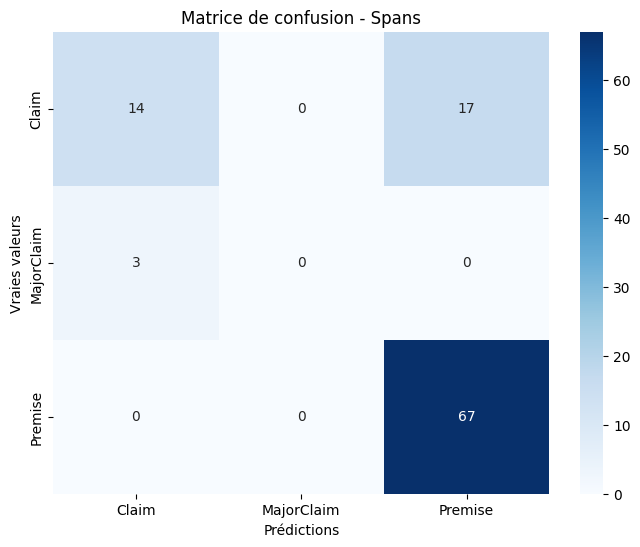

In [ ]:
# Affichage de la matrice de confusion pour la classification des spans
afficher_matrice_confusion(y_dev_spans, y_pred_spans, encodeur_spans.classes_, "Matrice de confusion - Spans")

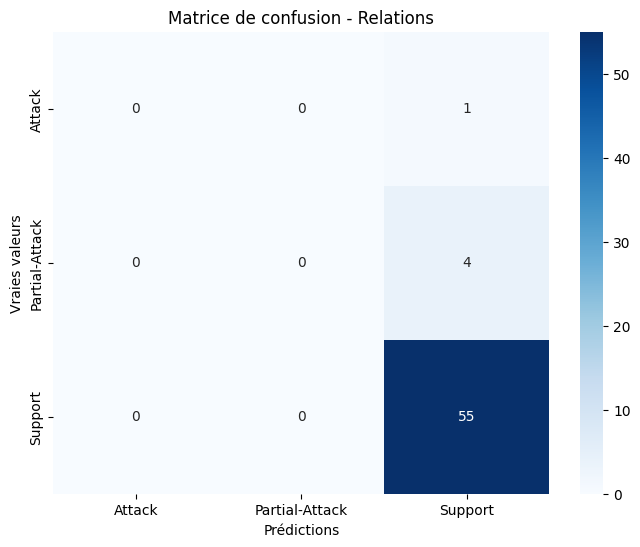

In [ ]:
# Affichage de la matrice de confusion pour la classification des relations
afficher_matrice_confusion(y_dev_relations, y_pred_relations, encodeur_relations.classes_, "Matrice de confusion - Relations")

In [ ]:
!python3 evaluate.py predictions_alignees.json abstrct_neoplasm_test.json




********************** SPANS *************************** 
   STRICT EVALUATION
    > Argument mining spans (unlabeled)
      Precision : 1.0 
      Recall    : 1.0
      F-score   : 1.0
    > Argument mining spans (labeled)
      Precision : 0.8134920634920634 
      Recall    : 0.8134920634920634 
      F-score   : 0.8134920634920635

    RELAXED EVALUATION (α = 0.5)
    > Argument mining spans (unlabeled)
      Precision : 1.0 
      Recall    : 1.0
      F-score   : 1.0
    > Argument mining spans (labeled)
      Precision : 0.8134920634920634 
      Recall    : 0.8134920634920634 
      F-score   : 0.8134920634920635



******************* RELATIONS *************************** 
   STRICT EVALUATION
    > Argument mining spans (unlabeled)
      Precision : 1.0 
      Recall    : 1.0
      F-score   : 1.0
    > Argument mining spans (labeled)
      Precision : 0.9333333333333333 
      Recall    : 0.9333333333333333 
      F-score   : 0.9333333333333333

    RELAXED EVALUATION (α =

In [ ]:
!python view_data.py aae_test.json


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
109	attending	I-Claim
110	to	I-Claim
111	the	I-Claim
112	same	I-Claim
113	school	I-Claim
114	,	I-Claim
115	students	I-Claim
116	can	I-Claim
117	learn	I-Claim
118	how	I-Claim
119	to	I-Claim
120	view	I-Claim
121	the	I-Claim
122	opposite	I-Claim
123	gender	I-Claim
124	in	I-Claim
125	classes	I-Claim
126	as	I-Claim
127	a	I-Claim
128	friend	I-Claim
129	or	I-Claim
130	a	I-Claim
131	classmate	I-Claim
132	.	O
133	In	O
134	addition	O
135	,	O
136	a	B-Premise
137	boy	I-Premise
138	would	I-Premise
139	know	I-Premise
140	how	I-Premise
141	to	I-Premise
142	speak	I-Premise
143	with	I-Premise
144	a	I-Premise
145	girl	I-Premise
146	in	I-Premise
147	every	I-Premise
148	situation	I-Premise
149	and	I-Premise
150	vice	I-Premise
151	versa	I-Premise
152	.	O
153	They	B-Premise
154	would	I-Premise
155	know	I-Premise
156	how	I-Premise
157	to	I-Premise
158	ask	I-Premise
159	her	I-Premise
160	in	I-Premise
161	order	I-Premise
162	to	I-Pre

In [ ]:
!pip install transformers datasets torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14

In [ ]:
import json
import torch
import numpy as np
from tqdm import tqdm
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from torch.utils.data import DataLoader, Dataset


In [ ]:
import os

print("Dossiers et fichiers disponibles à la racine :")
print(os.listdir("./"))


Dossiers et fichiers disponibles à la racine :
['view_data.py', 'aae_train.json', 'abstrct_neoplasm_train.json', 'abstrct_mixed_test.json', 'abstrct_neoplasm_test.json', 'Logistic.json', 'abstrct_neoplasm_dev.json', 'README.md', 'abstrct_glaucoma_test.json', 'aae_test.json', 'data', '.git', 'aae_dev.json', 'predictions_alignees.json', 'evaluate.py']


In [ ]:
# Charger les fichiers JSON
def load_json(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

train_data = load_json("aae_train.json")
test_data = load_json("aae_test.json")

# Transformer les labels en indices
LABELS = ["O", "B-Claim", "I-Claim", "B-Premise", "I-Premise"]  # Ajuste selon tes annotations
label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for label, i in label2id.items()}

# Charger le tokenizer RoBERTa avec `add_prefix_space=True`
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

# Tokenization et alignement des labels
def tokenize_and_align_labels(example):
    tokens = [token["str"] for paragraph in example["tokens"] for token in paragraph]  # Aplatir la liste

    tokenized_inputs = tokenizer(
        tokens, truncation=True, padding="max_length", max_length=512, is_split_into_words=True
    )

    labels = []
    word_ids = tokenized_inputs.word_ids(batch_index=0)
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
            labels.append(-100)  # Ignorer le padding et les sous-tokens
        else:
            labels.append(label2id.get(example["spans"][0]["name"], 0))  # Ajuste selon ton format
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Transformer les données en format Dataset PyTorch
class ArgumentDataset(Dataset):
    def __init__(self, data):
        self.data = [tokenize_and_align_labels(example) for example in data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.data[idx].items()}
        return item

train_dataset = ArgumentDataset(train_data)
test_dataset = ArgumentDataset(test_data)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
#Définition du modèle
model = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=len(LABELS))


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Ajouter le DataCollator pour gérer le padding dynamique
data_collator = DataCollatorForTokenClassification(tokenizer)


In [ ]:
#Entrainer le modèle RoBerta
import wandb
wandb.init(mode="disabled")

os.environ["WANDB_API_KEY"] = "fake_key"

# Désinstallation de wandb
!pip uninstall -y wandb

# Mise à jour de transformers
!pip install --upgrade transformers

Found existing installation: wandb 0.19.6
Uninstalling wandb-0.19.6:
  Successfully uninstalled wandb-0.19.6


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,  # Gestion du padding dynamique
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,No log,0.000207
2,No log,0.000120


Epoch,Training Loss,Validation Loss
1,No log,0.000207
2,No log,0.000120


In [ ]:
model.save_pretrained("./roberta_argument_mining")
tokenizer.save_pretrained("./roberta_argument_mining")

In [ ]:
import torch

# Vérifier si les poids du modèle ont été entraînés
print("Paramètres du modèle :")
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}, mean={param.data.mean():.4f}")

In [ ]:
# Sauvegarde correcte du modèle après l'entraînement
model_path = "./roberta_argument_mining"

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f" Modèle sauvegardé dans {model_path}")


In [ ]:
model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()  # Passer en mode évaluation


In [ ]:
# Avant entraînement
print("Poids initiaux du modèle :", model.classifier.weight.mean().item())

# Code d'entraînement ici...

# Après entraînement
print("Poids après entraînement :", model.classifier.weight.mean().item())

In [ ]:
print(model.state_dict().keys())  # Vérifie si les poids sont bien chargés


In [ ]:
#Initialisation du modèle et du tokenizer
MODEL_PATH = "./roberta_argument_mining"  # Assure-toi que ce modèle existe bien
TOKENIZER_NAME = "roberta-base"  # À adapter si nécessaire

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = RobertaTokenizerFast.from_pretrained(TOKENIZER_NAME, add_prefix_space=True)
model = RobertaForTokenClassification.from_pretrained(MODEL_PATH).to(device)
model.eval()

print(f"Modèle chargé sur {device}")


In [ ]:
def predict(tokens_list):
    predictions = []
    for i, tokens in enumerate(tokens_list):
        if not tokens:
            print(f"Avertissement : Aucun token à prédire pour le document {i}")
            predictions.append([])
            continue

        #Tokenization
        inputs = tokenizer(tokens, return_tensors="pt", is_split_into_words=True, padding=True, truncation=True)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        #Prédiction avec RoBERTa
        with torch.no_grad():
            outputs = model(**inputs).logits  # Obtenir les logits
            preds = torch.argmax(outputs, dim=-1).cpu().numpy()  # Obtenir les labels prédits

        #Stocker les résultats
        formatted_doc = {
            "tokens": tokens,
            "predicted_labels": preds.tolist()
        }
        predictions.append(formatted_doc)

    return predictions

predictions = predict(tokens_list)

#Vérifier un exemple de prédiction
print(f"Exemple de prédiction : {predictions[0]}")


In [ ]:
import os

output_dir = "outputs"
output_path = os.path.join(output_dir, "aae_test_predicted_roberta.json")

#Vérifie si le dossier existe, sinon le créer
if not os.path.exists(output_dir):
    print(f"Création du dossier : {output_dir}")
    os.makedirs(output_dir, exist_ok=True)

#Sauvegarde des prédictions
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(predictions, f, indent=4)

print(f"Prédictions enregistrées avec succès dans : {output_path}")


In [ ]:
!python3 evaluate.py outputs/aae_test_predicted_roberta.json aae_test.json --alpha 0.5
